In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs2/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs2/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band06_wn_1100_1215',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.3_.35_.95',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_saw')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs2/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'h2o',
                          'band06_wn_1100_1215',
                          'ng_3',
                          'g_ascending_k_descending',
                          'refPTs_P_600_T_250',
                          'ng_refs_3',
                          'getabsth_auto',
                          'absth_dlogN_uniform',
                          'wgt_.3_.35_.95',
                          'wgt_flux_2',
                          'wgt_k_1',
                          'klin_5e-25',
                          'crd_a3d1611',
                          'atmpro_saw')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [7]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [8]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [9]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [10]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 1100

nband = 115

nv = 200

dv = 0.005

tsfc = 257.0

ng = 3

nref = 1

p_refs = (/ 600 /)

t_refs = (/ 250 /)

ng_refs = (/ 3 /)

data wgt
     &     /.3, .35, .95/

option_wgt_flux = 2

option_wgt_k = 1

option_klin = 1

klin = 5e-25

include 'saw75.pro'


In [11]:
fig.display_hrefanchor()

In [12]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [13]:
table_dgdgs.display_hrefanchor()

In [14]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [15]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [16]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

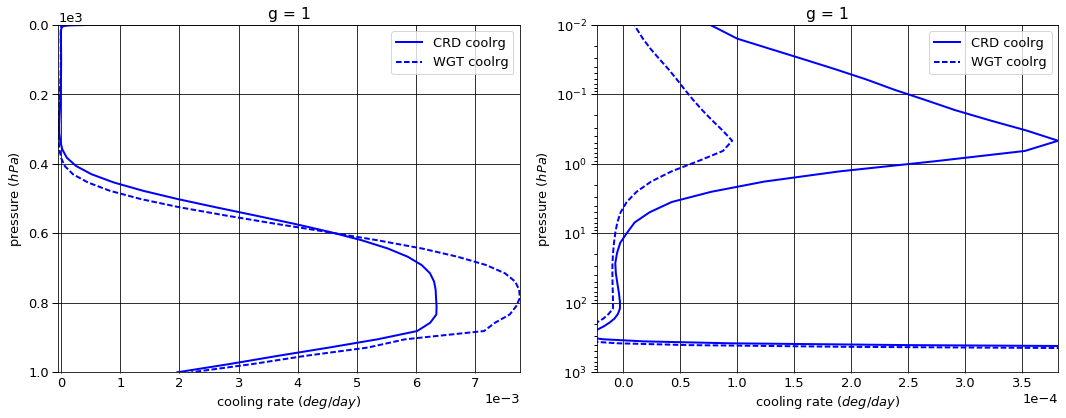

# Figure: cooling rate g-group 2

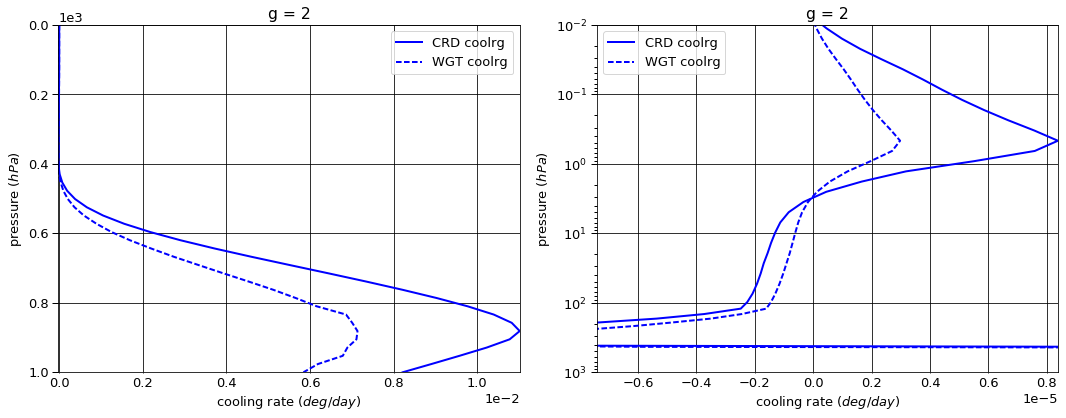

# Figure: cooling rate g-group 3

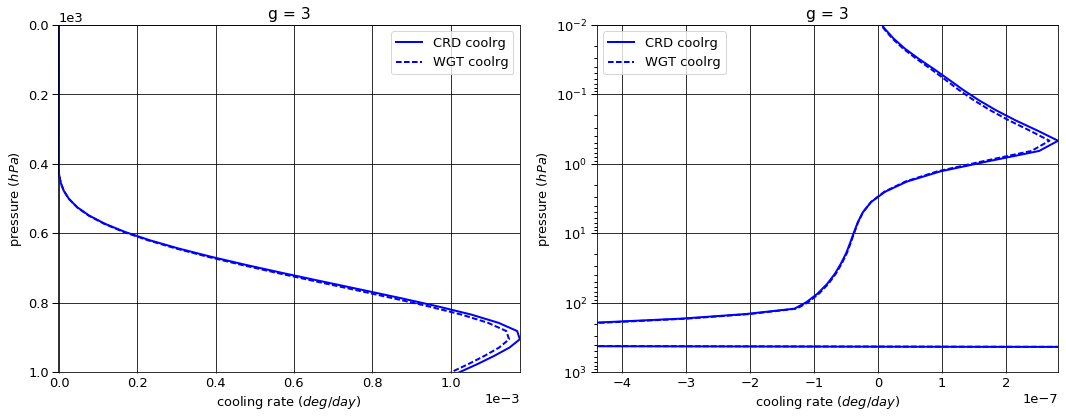

# Figure: cooling rate g-group total

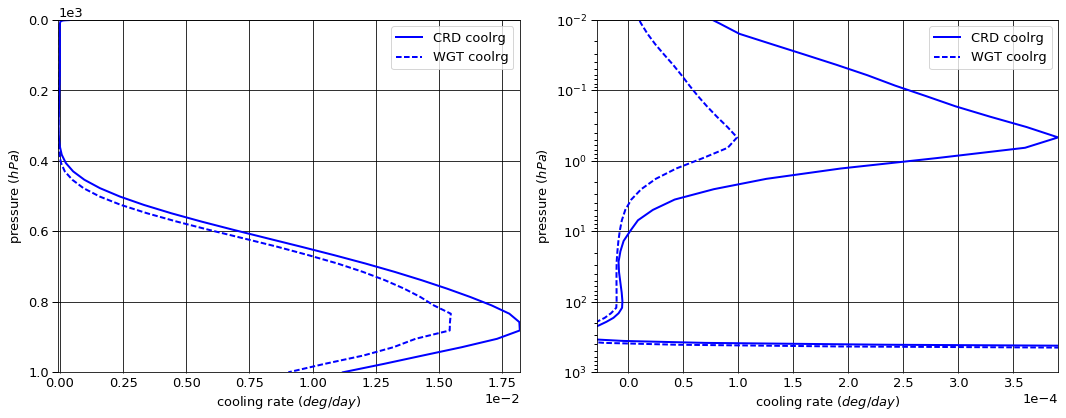

In [17]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [18]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.395468  0.000000 -0.395468
  1013.0   76    -0.457072  0.372697 -0.084375
2 0.0      1     -4.117088  0.000000 -4.117088
  1013.0   76    -4.137931  0.424621 -3.713310
3 0.0      1     -5.700769  0.000000 -5.700769
  1013.0   76    -5.702121  0.042416 -5.659705


WGT


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.402562  0.000000 -0.402562
  1013.0   76    -0.457072  0.397600 -0.059472
2 0.0      1     -4.126361  0.000000 -4.126361
  1013.0   76    -4.137931  0.272039 -3.865893
3 0.0      1     -5.700810  0.000000 -5.700810
  1013.0   76    -5.702121  0.041435 -5.660686


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.007094  0.000000 -0.007094
  1013.0   76     0.000000  0.024903  0.024903
2 0.0      1     -0.009272  0.000000 -0.009272
  1013.0   76     0.000000 -0.152582 -0.152582
3 0.0      1     -0.000041  0.000000 -0.000041
  1013.0   76     0.000000 -0.000981 -0.000981

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.730971e-06
  1001.112500 75     1.963541e-03
2 0.000312    1     -1.447967e-06
  1001.112500 75     8.214167e-03
3 0.000312    1     -3.335864e-08
  1001.112500 75     1.022352e-03


WGT


coolrg
g pressure    layer              
1 0.000312    1     -9.370951e-06
  1001.112500 75     2.199303e-03
2 0.000312    1     -5.571062e-07
  1001.112500 75     5.841109e-03
3 0.000312    1     -3.265016e-08
  1001.112500 75     1.000892e-03


WGT - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.639980e-06
  1001.112500 75     2.357623e-04
2 0.000312    1      8.908607e-07
  1001.112500 75    -2.373058e-03
3 0.000312    1      7.084810e-10
  1001.112500 75    -2.145950e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.213325,0.000000,-10.213325
1013.0,76,-10.297125,0.839734,-9.457391



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-10.229733,0.000000,-10.229733
1013.0,76,-10.297125,0.711074,-9.586051



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.016408,0.00000,-0.016408
1013.0,76,0.000000,-0.12866,-0.128660


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000006
1001.112500,75,0.011200



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.000010
1001.112500,75,0.009041



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000004
1001.112500,75,-0.002159


In [19]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.04613,0.044296
2,0.41687,0.401093
3,0.53700,0.554611


In [20]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.835681e-23
2,5.000596e-25
3,3.773541e-26


In [21]:
def spreadsheet():
    ng = crd.data['dgdgs'].dims['g']
    ng_refs = [3]
    p_refs = [600]
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [22]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet())

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.835681e-23,NaN,0.04613,0.044296,0.04613,0.044296,600.0
2,5.000596e-25,0.017635,0.41687,0.401093,0.46300,0.445389,600.0
3,3.773541e-26,0.075462,0.53700,0.554611,1.00000,1.000000,600.0


In [23]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [24]:
pd.set_option('display.max_rows', None)
display.display(
    pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1],
                sep=r'\s+')
    )
pd.reset_option('display.max_rows')

pressure       absmean    absmeanlog       ratio
layer g                                                     
1     1     0.000312  8.604036e-23  1.056374e-24   81.448793
      2     0.000312  3.130926e-25  9.659006e-27   32.414576
      3     0.000312  5.220476e-27  3.725776e-28   14.011783
2     1     0.000750  8.906576e-23  1.066604e-24   83.504048
      2     0.000750  3.221395e-25  9.817193e-27   32.813809
      3     0.000750  5.409292e-27  3.800908e-28   14.231578
3     1     0.001052  9.543861e-23  1.086483e-24   87.841770
      2     0.001052  3.411427e-25  1.013622e-26   33.655809
      3     0.001052  5.816442e-27  3.953912e-28   14.710603
4     1     0.001476  1.022599e-22  1.106520e-24   92.415772
      2     0.001476  3.614314e-25  1.046488e-26   34.537548
      3     0.001476  6.267236e-27  4.112494e-28   15.239502
5     1     0.002070  1.094646e-22  1.126520e-24   97.170637
      2     0.002070  3.828355e-25  1.079912e-26   35.450619
      3     0.002070  6.761076e-27  4.274817e-28   15.816061
6     1     0.002904  1.170661e-22  1.146603e-24  102.098160
      2     0.002904  4.054238e-25  1.113910e-26   36.396458
      3     0.002904  7.302801e-27  4.441307e-28   16.442909
7     1     0.004074  1.250775e-22  1.166971e-24  107.181300
      2     0.004074  4.292729e-25  1.148553e-26   37.375113
      3     0.004074  7.897863e-27  4.612929e-28   17.121146
8     1     0.005714  1.335135e-22  1.187931e-24  112.391620
      2     0.005714  4.544718e-25  1.183992e-26   38.384694
      3     0.005714  8.552515e-27  4.791295e-28   17.850113
9     1     0.008015  1.423865e-22  1.209927e-24  117.681880
      2     0.008015  4.811122e-25  1.220487e-26   39.419682
      3     0.008015  9.273632e-27  4.978600e-28   18.626988
10    1     0.011243  1.517113e-22  1.233606e-24  122.981980
      2     0.011243  5.093034e-25  1.258471e-26   40.470016
      3     0.011243  1.006918e-26  5.177691e-28   19.447236
11    1     0.015771  1.615005e-22  1.259879e-24  128.187290
      2     0.015771  5.391619e-25  1.298594e-26   41.518887
      3     0.015771  1.094801e-26  5.392035e-28   20.304046
12    1     0.022122  1.717665e-22  1.290031e-24  133.149140
      2     0.022122  5.708171e-25  1.341803e-26   42.541051
      3     0.022122  1.192015e-26  5.626009e-28   21.187578
13    1     0.031031  1.824719e-22  1.325746e-24  137.637210
      2     0.031031  6.042607e-25  1.389269e-26   43.494880
      3     0.031031  1.299193e-26  5.884433e-28   22.078474
14    1     0.043528  1.923434e-22  1.367054e-24  140.699180
      2     0.043528  6.355592e-25  1.438542e-26   44.180796
      3     0.043528  1.403642e-26  6.148493e-28   22.829047
15    1     0.061057  2.002131e-22  1.414643e-24  141.529000
      2     0.061057  6.609035e-25  1.488120e-26   44.411986
      3     0.061057  1.491214e-26  6.402405e-28   23.291469
16    1     0.085645  2.071786e-22  1.473945e-24  140.560630
      2     0.085645  6.836869e-25  1.544672e-26   44.260976
      3     0.085645  1.572264e-26  6.680932e-28   23.533601
17    1     0.120136  2.142719e-22  1.551369e-24  138.117960
      2     0.120136  7.072600e-25  1.615770e-26   43.772324
      3     0.120136  1.658416e-26  7.024876e-28   23.607760
18    1     0.168516  2.215153e-22  1.652541e-24  134.045280
      2     0.168516  7.317817e-25  1.707122e-26   42.866390
      3     0.168516  1.750535e-26  7.462318e-28   23.458324
19    1     0.236378  2.288959e-22  1.784282e-24  128.284630
      2     0.236378  7.573252e-25  1.826391e-26   41.465668
      3     0.236378  1.849248e-26  8.032339e-28   23.022528
20    1     0.331549  2.363924e-22  1.954954e-24  120.919680
      2     0.331549  7.839717e-25  1.983949e-26   39.515718
      3     0.331549  1.955284e-26  8.790037e-28   22.244317
21    1     0.465100  2.431771e-22  2.172236e-24  111.947840
      2     0.465100  8.090462e-25  2.189884e-26   36.944702
      3     0.465100  2.058345e-26  9.787359e-28   21.030645
22    1     0.652400  2.372316e-22  2.398562e-2

# Histogram of wavenumbers in g-group 1

In [25]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [26]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
